<a href="https://colab.research.google.com/github/safakatakancelik/rag-system-00-and-eval/blob/master/evaluation/RAG_Evaluation_with_Ragas_%2B_Ollama.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install Ollama and essential libraries
!curl -fsSL https://ollama.com/install.sh | sh
!pip install ragas langchain_ollama datasets langchain_community -q

import subprocess
import time

# Start Ollama server in the background
subprocess.Popen(['ollama', 'serve'])
time.sleep(5) # Give it a moment to wake up

# Pull the smarter judge model
!ollama pull qwen2.5:7b
!ollama pull nomic-embed-text

>>> Installing ollama to /usr/local
>>> Downloading Linux amd64 bundle
######################################################################## 100.0%
>>> Creating ollama user...
>>> Adding ollama user to video group...
>>> Adding current user to ollama group...
>>> Creating ollama systemd service...
>>> The Ollama API is now available at 127.0.0.1:11434.
>>> Install complete. Run "ollama" from the command line.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 419.9/419.9 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 90.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 72.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.9/160.9 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.7/84.7 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from datasets import Dataset

In [3]:
df = pd.read_csv("https://raw.githubusercontent.com/safakatakancelik/rag-system-00-and-eval/refs/heads/master/evaluation/test_responses.csv")
df

,Unnamed: 0,question,ground_truth,contexts,answer
0,521,Mohamed Naguib Hamed is an athlete from what t...,Egypt,['Mohamed Naguib Hamed (Arabic: محمد نجيب حامد...,Mohamed Naguib Hamed is an athlete from Egypt.
1,737,What bill president Clinton sign at the school...,Goals 2000,"['""Vast right-wing conspiracy"" is a conspiracy...","President Bill Clinton signed the ""Goals 2000""..."
2,740,Salvador Duran Sanchez raced in which series w...,A1 Grand Prix,['Salvador Durán Sánchez (born 6 May 1985) is ...,Salvador Duran Sanchez raced in A1 Grand Prix ...
3,660,"Along with Barbara Bush, what other member of ...",Jenna Bush,"['Barbara Pierce Bush Jr. (born November 25, 1...","Along with Barbara Bush, Jenna Bush has also b..."
4,411,When was the first series premiered in the UK ...,15 January 2012,['Amy McAllister is an Irish actress most nota...,Amy McAllister is most notable for her role as...
...,...,...,...,...,...
95,436,What is the nationality of the company that pr...,French,"['Inside (French: ""À l\'intérieur"" ) is a 2007...","I am sorry, but the context does not contain a..."
96,764,Bacon is a native of a city whose nickname is ...,Queen City of the Ozarks,"['Bacon is a native of Springfield, Missouri, ...",The provided context does not mention the nick...
97,88,"In 2014, Clemson Tigers football team were inv...",Bob Stoops,['The 2014 Clemson Tigers football team repres...,"In 2014, the Clemson Tigers defeated Oklahoma ..."
98,63,Uyirodu Uyiraga was a film that starred the In...,British Formula 3 season,"[""Uyirodu Uyiraga (Tamil: உயிரோடு உயிராக ) is ...",The 1998 film Uyirodu Uyiraga starred Ajith Ku...


In [4]:
import ast
df['contexts'] = df['contexts'].apply(ast.literal_eval) # typecast to list to prevent eval pipeline error
eval_dataset = Dataset.from_pandas(df)

In [ ]:
import os
from openai import OpenAI
from ragas.llms import llm_factory
from ragas import evaluate
from ragas.metrics import faithfulness, answer_correctness, context_recall
from ragas.run_config import RunConfig
from langchain_ollama import OllamaEmbeddings # Import this directly

# 1. Initialize modern OpenAI-compatible client for Ollama
client = OpenAI(base_url="http://localhost:11434/v1", api_key="ollama")

# 2. Use the factory for the LLM
judge_llm = llm_factory("qwen2.5:7b", provider="openai", client=client)

# 3. Use LangChain's OllamaEmbeddings directly
# Ragas 0.2 automatically handles these objects when passed to evaluate()
judge_embeddings = OllamaEmbeddings(model="nomic-embed-text")

# 4. Configure to prevent timeouts and parsing errors
config = RunConfig(max_workers=1, timeout=600, max_retries=3)

# 5. Run Evaluation
print("Evaluating with Qwen 2.5 7B & Nomic Embeddings...")
results = evaluate(
    eval_dataset,
    metrics=[faithfulness, answer_correctness, context_recall],
    llm=judge_llm,
    embeddings=judge_embeddings, # Pass the object directly
    run_config=config
)

In [11]:
results

{'faithfulness': 0.7796, 'answer_correctness': 0.5945, 'context_recall': 0.6975}

In [12]:
results_df = pd.DataFrame.from_dict([results])

In [8]:
results_df.to_csv("EvaluationResults.csv")

In [19]:
results_df["scores"]

,scores,dataset,binary_columns,cost_cb,traces,ragas_traces,run_id
0,"[{'faithfulness': 0.0, 'answer_correctness': 0...",{'samples': [user_input='Mohamed Naguib Hamed ...,[],None,"[{'scores': {'faithfulness': 0.0, 'answer_corr...",{'019b47c7-6d24-7b51-b39c-d487541b48af': run_i...,None


In [31]:
# Get the list of scores from results_df
scores_list = results_df["scores"][0]

# Convert the list of dictionaries to a DataFrame for easier manipulation
scores_df = pd.DataFrame(scores_list)

# 1. Error percentage for each metric (where value is NaN)
print("\n--- Error Percentage (NaN values) for each metric ---")
total_samples = len(scores_df)
metrics = ['faithfulness', 'answer_correctness', 'context_recall']

error_data = []
for metric in metrics:
    nan_count = scores_df[metric].isnull().sum()
    error_percentage = (nan_count / total_samples) * 100
    error_data.append({'Metric': metric.replace('_', ' ').capitalize(), 'NaN Percentage': f'{error_percentage:.2f}%'})

error_df = pd.DataFrame(error_data)
print(error_df.to_string(index=False))


--- Error Percentage (NaN values) for each metric ---
            Metric NaN Percentage
      Faithfulness          2.00%
Answer correctness          6.00%
    Context recall          0.00%



--- Plotting Metric Distributions ---


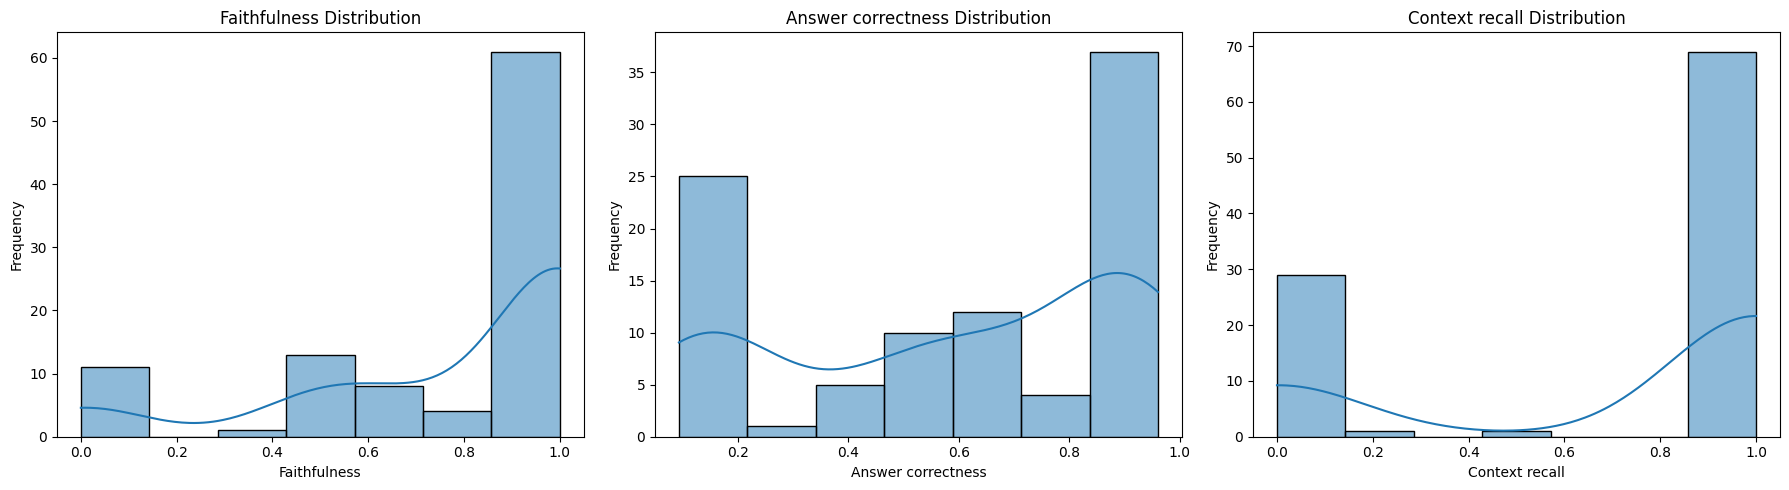

In [29]:
# 2. Plot of each metrics value distribution
print("\n--- Plotting Metric Distributions ---")

plt.figure(figsize=(18, 5))

for i, metric in enumerate(metrics):
    plt.subplot(1, 3, i + 1)
    sns.histplot(scores_df[metric].dropna(), kde=True, bins=7)
    plt.title(f'{metric.replace("_", " ").capitalize()} Distribution')
    plt.xlabel(metric.replace('_', ' ').capitalize())
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()